# Reversible Carry Select Adder in qiskit 

Author: Mattia Capparella  
Contact: <capparella.1746513 AT studenti.uniroma1.it>  
Course: Intensive Computation  
AA: 2021-2022  
***

In this notebook I am going to implement 3 versions of the RCSA_ circuit proposed in [1]:

1. CSA - design 1, with building blocks of **1** qubit (as in the paper)
2. CSA - design 1, with building blocks of **4** qubits (first alternative)
3. CSA - design 1, with building blocks of **2** qubits (second alternative)


[1] https://ieeexplore.ieee.org/document/9016873, "Reverse Carry Select Adder with Online Testability Using Reversible Gates"

In the paper the performance analysis is verified in terms of Ancilla, Quantum Cost and Garbage Outputs.
Also, the authors make the claim that their CSA is faster as compared to a Ripple Carry Adder (RCA) because of the delay induced by the *c_out* that must be propagated through each of the FAs before the next one can start adding its operands.  

The goal of this notebook is thus verify wheter or not if either their version of CSA or my alternatives are actually faster than the RCA.
Since it is not specified which RCA implementation is used, I assumed it to be the RCA described in [2].  

The problem of working with **local resources** is that timing the simulation **won't reflect the actual speed of these circuits**, so further analysis must be condected to verify if the authors claim about speed is correct, but a quantitative analysis about the 3 metrics mentioned before, plus the depth of the circuits, can be conducted.  


[2] https://arxiv.org/pdf/quant-ph/0410184.pdf, "A new quantum ripple-carry addition circuit"

In [83]:
import pprint as pp
import qiskit
from qiskit import QuantumRegister, ClassicalRegister, AncillaRegister, QuantumCircuit, Aer, transpile
from qiskit.providers.aer import AerSimulator
import matplotlib.pyplot as plt


qiskit.__qiskit_version__

{'qiskit-terra': '0.20.2', 'qiskit-aer': '0.10.4', 'qiskit-ignis': '0.7.1', 'qiskit-ibmq-provider': '0.19.1', 'qiskit-aqua': None, 'qiskit': '0.36.2', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

## Ausiliary Gates Implementations
* controlled SXdgGate
* Peres gate
* FA

In [84]:
"""
Controlled Version of SXdgGate. 
"""

from qiskit.circuit.library import SXdgGate

csxdg = SXdgGate().control(1)

This version of the reversible Peres Gate was seen in [3] and works fine, but the gates used to implement it seem so "complex" that when simulating *n qubits CSAs*, with `n > 2`, the computation requires a proibhitive amount of memory (for 3-quibits addends it requires more than 500000MB).

```
qc_peres = QuantumCircuit(3)
qc_peres.append(csxdg, qargs=[0,2])
qc_peres.append(csxdg, qargs=[1,2])
qc_peres.cnot(0,1)
qc_peres.csx(1,2)
```

So, in the following cell I've used a simpler implementation of the gate, as seen in [4].


[3] https://arxiv.org/abs/1407.7101, "Efficient design of Reversible Sequential Circuit"
[4] https://github.com/edogab33/ReversibleCarrySelectAdder, "ReversibleCarrySelectAdder"

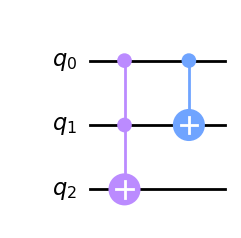

In [85]:
"""
Peres Gate implementation.

Parameters
----------
A
B
C

Returns
-------
P = A
Q = A XOR B
R = AB XOR C
"""

qc_peres = QuantumCircuit(3)
qc_peres.ccx(0,1,2)
qc_peres.cx(0,1)

PeresGate = qc_peres.to_gate(label="PG")

qc_peres.draw(output='mpl')


In [86]:
def generate_binary_strings(bit_count: int) -> list:
    """Helper function to generate all possible binary strings of a given length.
    
    Parameters
    ----------
    bit_count : int 

    Returns
    -------
    list of strings
    """


    binary_strings = []
    def genbin(n, bs=''):
        if len(bs) == n:
            binary_strings.append(bs)
        else:
            genbin(n, bs + '0')
            genbin(n, bs + '1')


    genbin(bit_count)
    return binary_strings

def simulate_circuit(inpts: list, circuit_generator) -> QuantumCircuit:
    """Helper function to simulate Peres and FA circuits on a list of inputs.
    
    Parameters
    ----------
    inpts : list of 3 bits string represent a,b,c

    Prints
    -------
    the result of the simulation for every input

    Returns
    -------
    the instance of the QuantumCircuit genereated by circuit_generator, with the last input used
    """

    
    for inp in inpts:
    # create the circuit
        qc = circuit_generator(*inp)
        
        # simulate it
        backend = AerSimulator() 
        qc_compiled = transpile(qc, backend)
        job_sim = backend.run(qc_compiled, shots=1, memory=True)
        output = job_sim.result().get_memory()[0]

        # print the result
        print("in: {} \t out: {}".format(inp, output))
    
    return qc

in: 000 	 out: 000
in: 001 	 out: 001
in: 010 	 out: 010
in: 011 	 out: 011
in: 100 	 out: 110
in: 101 	 out: 111
in: 110 	 out: 101
in: 111 	 out: 100


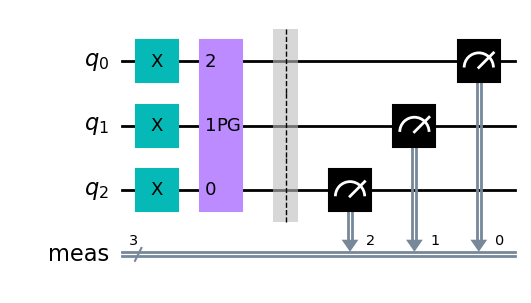

In [87]:
def Peres(a: str, b: str, c:str) -> QuantumCircuit:
    """Generate a Peres circuit, with the input encoding and measurement circuitries.
    
    
    Parameters
    ----------
    a,b,c : str
    
    Returns
    -------
    qc: QuantumCircuit
    """


    inputs = [a,b,c]
    qc = QuantumCircuit(3)
    
    # encode the input
    for i in range(len(inputs)):
        if inputs[i] == '1':
            qc.x(i)

    # perform the operation
    qc.append(PeresGate, qargs=[0,1,2])

    # measure the output
    qc.measure_all(inplace=True) # save space
    qc = qc.reverse_bits() # measure_all() follows the BE order -> revert it

    return qc

inputs = generate_binary_strings(3)

c_peres = simulate_circuit(inputs, Peres)

# plot the circuit (note: the input is 111, the last one)
c_peres.draw(output='mpl')

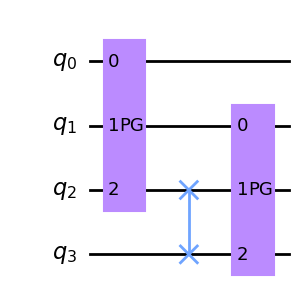

In [88]:
"""
FA implementation using Peres Gates.

Parameters
----------
A : first operand
B : second operand 
0 - ancilla
C_in : carry in (0 or 1)

Returns
-------
P' = A
P'' = A XOR B
Sum
C_out
"""

qc_fa = QuantumCircuit(4)
qc_fa.append(PeresGate, qargs=[0,1,2])
qc_fa.swap(2,3)
qc_fa.append(PeresGate, qargs=[1,2,3]) # we could invert 3,2 and save a swap gate, but the resulting circuit is messier

# create a FA "Gate"
FA = qc_fa.to_gate(label="FA")

# draw the circuit
qc_fa.draw(output='mpl')

    abc 	      cs
in: 000 	 out: 00
in: 001 	 out: 01
in: 010 	 out: 01
in: 011 	 out: 10
in: 100 	 out: 01
in: 101 	 out: 10
in: 110 	 out: 10
in: 111 	 out: 11


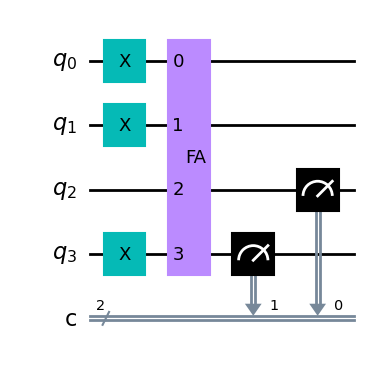

In [89]:
def FullAdderPeres(a:str, b:str, c:str) -> QuantumCircuit:
    """Generate a Full Adder circuit, implemented with Peres gates, with the input encoding and measurement circuitries.
    
    
    Parameters
    ----------
    a : first operand
    b : second operand
    c : carry in (0 or 1)
    
    Returns
    -------
    qc: QuantumCircuit
    """



    ancilla = '0'
    inputs = [a, b, ancilla, c]
    qc = QuantumCircuit(4,2)
    
    # encode the input
    for i in range(len(inputs)):
        if inputs[i] == '1':
            qc.x(i)
    
    # perform the operation
    qc.append(FA, qargs=[0,1,2,3])

    # measure the output
    qc.measure(3,1) # carry -> MSB
    qc.measure(2,0) # sum   -> LSB

    return qc

inputs = generate_binary_strings(3)

print("    abc \t      cs")

c_FA = simulate_circuit(inputs, FullAdderPeres)

# plot the circuit (note: the input is 111, the last one)
c_FA.draw(output='mpl')

## RCSA_ - design 1

![Semantic description of image](RCSA_design_1.gif)

Reversible carry select adder - design 1


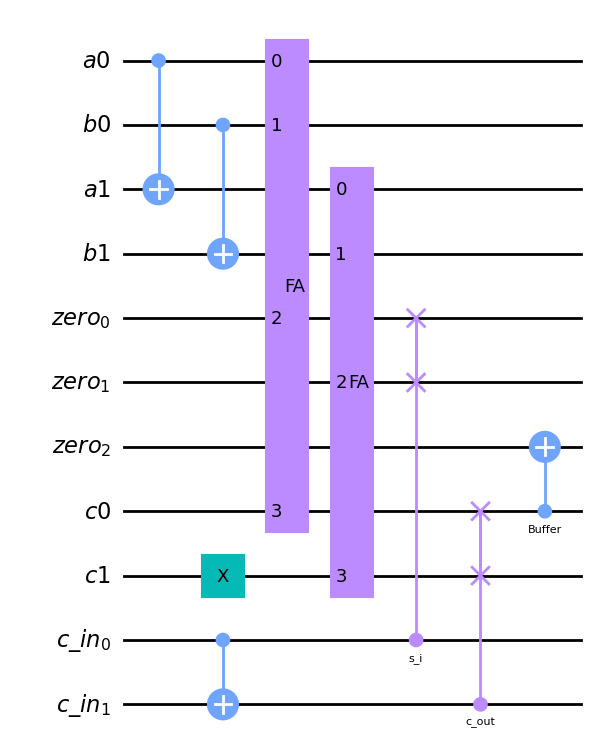

In [90]:
"""
8-bit RCSA_ 'design1' implementation, with block size = 1 (as seen in paper).

Parameters
----------
Quantum Registers:
    OPERANDS
    a0: first operand
    b0: second operand
    a1: copy of first operand
    b1: copy of second operand
    
    CARRIES
    c_in: carry_in
        c_in: input carry
        c_in_: copy of input carry

Ancilla Registers:
    CARRIES
    cX: RFA carries
        c0: (fixed) carry of the first RFA
        c1: (fixed) carry of the second RFA
    
    ANCILLAE
    zero:
        RFA: ancilla of the first RFA
        RFA_: ancilla of the second RFA
        CNOT: ancilla of the CNOT "buffer"


Returns
-------



"""

a0 = QuantumRegister(1, name='a0')
b0 = QuantumRegister(1, name='b0')
a1 = QuantumRegister(1, name='a1')
b1 = QuantumRegister(1, name='b1')
c_in = QuantumRegister(2, name='c_in')  # TODO: check if it can be reduce to 1, since it does not get dirty
#c = AncillaRegister(2, name='c')        
c0 = AncillaRegister(1, name='c0')
c1 = AncillaRegister(1, name='c1')        
zero = AncillaRegister(3, name='zero')  # here used for: RFAs and CNOT "Buffer" 

qc_rcsa = QuantumCircuit(a0, b0, a1, b1, zero, c0, c1, c_in)

# encode the input
qc_rcsa.cx(a0, a1)
qc_rcsa.cx(b0, b1)
qc_rcsa.x(c1)
qc_rcsa.cx(c_in[0], c_in[1])


# perform the operations
qc_rcsa.append(FA, qargs=[a0, b0, zero[0], c0])
qc_rcsa.append(FA, qargs=[a1, b1, zero[1], c1])
qc_rcsa.cswap(c_in[0], zero[0], zero[1], label="s_i") # s
qc_rcsa.cswap(control_qubit=c_in[1], target_qubit1 = c0, target_qubit2 = c1, label="c_out") # c_out
qc_rcsa.cx(c0, zero[2], label="Buffer")


qc_rcsa.draw(output="mpl")

In [91]:
from typing import List, Union

def RCSA(n: int, a_inp:str, b_inp:str, c_inp:str) -> QuantumCircuit:
    """Implements a circuit for an n-bit RCSA.


    Parameters
    ----------


    Returns
    -------
    """

    name = "RCSA design 1"      # TODO: instead of a function, implement a class

    a_inp = a_inp[::-1] # read from LSB to MSB
    b_inp = b_inp[::-1]

    a0 = QuantumRegister(n, name='a0')
    b0 = QuantumRegister(n, name='b0')
    a1 = QuantumRegister(n, name='a1')
    b1 = QuantumRegister(n, name='b1')
    zero0 = AncillaRegister(n, name='zero0')
    zero1 = AncillaRegister(n, name='zero1')
    c0 = AncillaRegister(n, name='c0')
    c1 = AncillaRegister(n, name='c1')
    c_in = QuantumRegister(2, name='c_in')
    zero_BUF = AncillaRegister(n-1, name='zero_BUF')

    result = ClassicalRegister(n+1, name='result') # +1 to consider the carry

    qc_rcsa = QuantumCircuit(a0, b0, a1, b1, zero0, zero1, c0, c1, c_in,  zero_BUF, result)

    # encode the input
    if c_inp == '1':
        qc_rcsa.x(c_in[0])

    for i in range(n):
        if a_inp[i] == '1':
            qc_rcsa.x(a0[i])
        if b_inp[i] == '1':
            qc_rcsa.x(b0[i])
        qc_rcsa.reset(a1[i])
        qc_rcsa.reset(b1[i])
        qc_rcsa.cx(a0[i], a1[i]) # copy a -> a_
        qc_rcsa.cx(b0[i], b1[i]) # copy b -> b_
        qc_rcsa.reset(c0[i])     # set c0 = 0
        qc_rcsa.reset(c1[i])
        qc_rcsa.x(c1[i])        # set c1 = 1
        qc_rcsa.reset(zero0[i])
        qc_rcsa.reset(zero1[i])
    qc_rcsa.reset(c_in[1])
    qc_rcsa.cx(c_in[0], c_in[1]) # copy c_in[0] -> c_in[1] 


    # perform the operations
    for i in range(n):
        qc_rcsa.append(FA, qargs=[a0[i], b0[i], zero0[i], c0[i]])
        qc_rcsa.append(FA, qargs=[a1[i], b1[i], zero1[i], c1[i]])
        if i == 0:
            qc_rcsa.cswap(c_in[1], zero0[i], zero1[i])   # c_out
            qc_rcsa.cswap(c_in[0], c0[i], c1[i])        # s
        else:
            qc_rcsa.cswap(c0[i-1], zero0[i], zero1[i])   # c_out    # it may be: c0[i-1], zero[i], zero_[i] 
            qc_rcsa.cswap(zero_BUF[i-1], c0[i], c1[i])  # s        # it may be: c[i-1], zero[i], zero_[i] 
        
        #qc_rcsa.measure(c0[i], result[i]) # measure the s
        qc_rcsa.measure(zero0[i], result[i])

        if i < (n-1):
            qc_rcsa.cx(c0[i], zero_BUF[i])
        else:
            qc_rcsa.measure(c0[i], result[i+1]) 

  
    return qc_rcsa

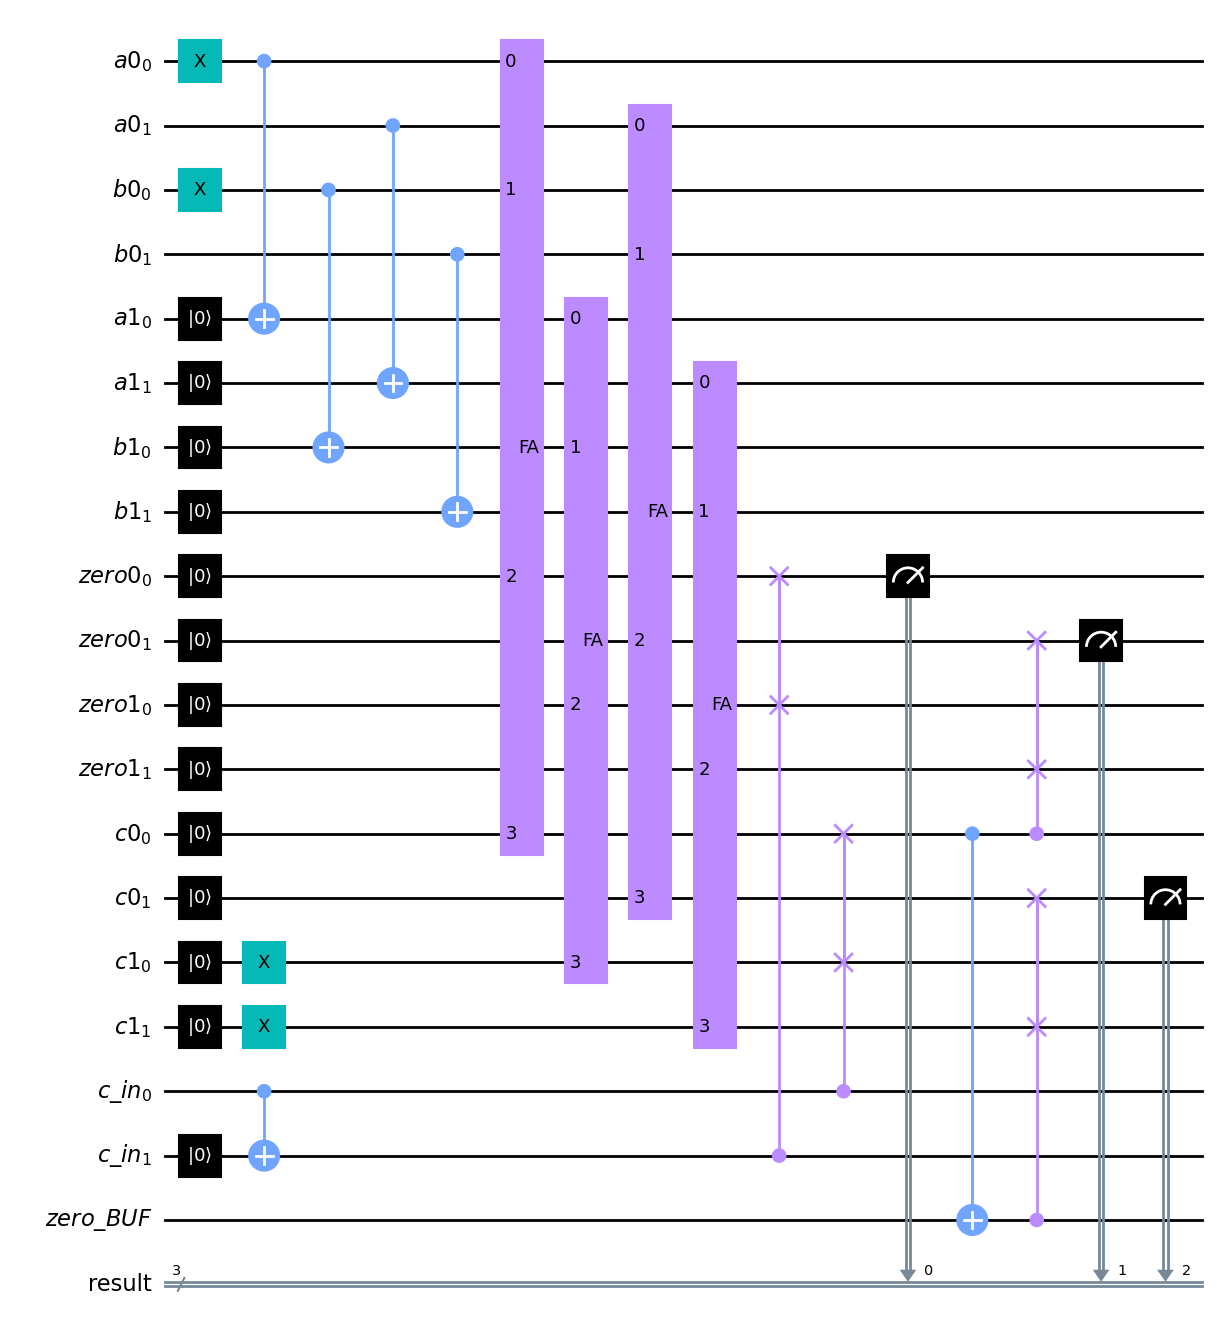

In [92]:
RCSA_ = RCSA(2, '01', '01', '0')
RCSA_.draw(output="mpl")

Simulate the RCSA - design 1, check its correctness and perform circuit analysis.

In [207]:
import random



def check_correctness(n: int, carry_in: str, circuitGenerator, getRandomInputs=False, nInp = 5):
    """ Checks the correctness of the RCSA circuit: 

    # BEWARE: if `n == 3` -> the simulation is inexplicably slow (it takes ~1 min per simulation)
    
    1. Generates all possible inputs of length n
    2. Generates a `circuitGenerator` circuit for each pair of inputs and the given carry_in
    3. Simulates the circuit and prints the output: (operands and result)


    Parameters
    ----------
    n : operands length
    carry_in : fixed carry_in for all the simulations
    circuitGenerator : circuit to simulate
    getRandomInputs : if True, picks a random subset of all possible inputs.
                      tip: use it when `n > 5` to avoid taking too long to run the simulation.

    Returns
    -------
    print the result of the simulation for each pair of inputs
    """

    def isCorrect(n: int, a: str, b: str, c: str,  sim_res: str) -> bool:
        """ Checks if the result of the simulation is correct. 
        
        
        Parameters
        ----------
        n : operands length
        a : operand a
        b : operand b
        c : carry_in
        sim_res : result of the simulation

        Returns
        -------
        True if the simulation result is correct, False otherwise
        
        """

        sum_ = bin( int(a,2) + int(b,2) + int(c, 2) )[2:] # `bin` result starts with 0xb 
        sum_ = sum_.zfill(n+1) # consider also the c_out
        
        return sum_ == result_sim


        


    assert n != 3, "The simulation is inexplicably slow for n == 3"
        

    inputs = generate_binary_strings(n)
    
    if getRandomInputs:
        inputs = random.sample(inputs, nInp)
    
    print(inputs)
    #print(len(inputs))

    print("abc \t\t c s\n-------------")
    for a in range(len(inputs)):
        for b in range(len(inputs)):
            qc = circuitGenerator(n, inputs[a], inputs[b], carry_in)
            
            #usim = Aer.get_backend('unitary_simulator')
            #transpiled = transpile(qc, backend=usim)
            #backend = Aer.get_backend('aer_simulator')
            #job = backend.run(transpiled, shots=1, memory=True)
            #result_sim = job.result().get_memory()[0]
            
            backend = AerSimulator() #Aer.get_backend('aer_simulator')
            qc_compiled = transpile(qc, backend)
            job_sim = backend.run(qc_compiled, shots=1, memory=True)
            result_sim = job_sim.result().get_memory()[0]

            iscorrect = isCorrect(n, inputs[a], inputs[b], carry_in, result_sim)
            

            print("{}+{}+{} \t {} {} {}".format(inputs[a], inputs[b], int(carry_in), result_sim[0], result_sim[1:], iscorrect))


def circuit_analysis(n, circuit_generator, name="CIRCUIT NAME", Transpile=False, optLevel=None, displayCircuit=False):
    """Measure the depth, the width and the count_ops of a circuit, whose input has lenght n"""
    
    inpt = "0" * n
    c_in = "0"
    qc = circuit_generator(n, inpt, inpt, c_in)

    
    if not Transpile:    
        print("\n{}-bit {} analysis:\n-------------------".format(n, name))
        print("depth: {}\nwidth:{}".format(qc.depth(), qc.width()))
        pp.pprint({'count_ops': dict(qc.count_ops())} )
        
        if displayCircuit:
            qc.draw(output="mpl")

    else:
        print("{}-bit {}-Transpiled analysis:\n-------------------".format(n, name))
        backend = Aer.get_backend('aer_simulator')
        qc_compiled = transpile(qc, backend, optimization_level=optLevel)
        print("depth: {}\nwidth:{}".format(qc_compiled.depth(), qc_compiled.width()))
        pp.pprint({'count_ops': dict(qc_compiled.count_ops())} )
        if displayCircuit:
            qc_compiled.draw(output="mpl")
                        

In [106]:
check_correctness(2,'0', RCSA)

['00', '01', '10', '11']
abc 		 c s
-------------
00+00+0 	 0 00 True
00+01+0 	 0 01 True
00+10+0 	 0 10 True
00+11+0 	 0 11 True
01+00+0 	 0 01 True
01+01+0 	 0 10 True
01+10+0 	 0 11 True
01+11+0 	 1 00 True
10+00+0 	 0 10 True
10+01+0 	 0 11 True
10+10+0 	 1 00 True
10+11+0 	 1 01 True
11+00+0 	 0 11 True
11+01+0 	 1 00 True
11+10+0 	 1 01 True
11+11+0 	 1 10 True


In [107]:
check_correctness(4,'1', RCSA)

['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']
abc 		 c s
-------------
0000+0000+1 	 0 0001 True
0000+0001+1 	 0 0010 True
0000+0010+1 	 0 0011 True
0000+0011+1 	 0 0100 True
0000+0100+1 	 0 0101 True
0000+0101+1 	 0 0110 True
0000+0110+1 	 0 0111 True
0000+0111+1 	 0 1000 True
0000+1000+1 	 0 1001 True
0000+1001+1 	 0 1010 True
0000+1010+1 	 0 1011 True
0000+1011+1 	 0 1100 True
0000+1100+1 	 0 1101 True
0000+1101+1 	 0 1110 True
0000+1110+1 	 0 1111 True
0000+1111+1 	 1 0000 True
0001+0000+1 	 0 0010 True
0001+0001+1 	 0 0011 True
0001+0010+1 	 0 0100 True
0001+0011+1 	 0 0101 True
0001+0100+1 	 0 0110 True
0001+0101+1 	 0 0111 True
0001+0110+1 	 0 1000 True
0001+0111+1 	 0 1001 True
0001+1000+1 	 0 1010 True
0001+1001+1 	 0 1011 True
0001+1010+1 	 0 1100 True
0001+1011+1 	 0 1101 True
0001+1100+1 	 0 1110 True
0001+1101+1 	 0 1111 True
0001+1110+1 	 1 0000 True
0001+1111+1 	 1 0001 True
0010+0000+1 	 

In [108]:
check_correctness(8, '0', RCSA, getRandomInputs=True)

['11100100', '01100010', '01011010', '11001110', '11000011']
abc 		 c s
-------------
11100100+11100100+0 	 1 11001000 True
11100100+01100010+0 	 1 01000110 True
11100100+01011010+0 	 1 00111110 True
11100100+11001110+0 	 1 10110010 True
11100100+11000011+0 	 1 10100111 True
01100010+11100100+0 	 1 01000110 True
01100010+01100010+0 	 0 11000100 True
01100010+01011010+0 	 0 10111100 True
01100010+11001110+0 	 1 00110000 True
01100010+11000011+0 	 1 00100101 True
01011010+11100100+0 	 1 00111110 True
01011010+01100010+0 	 0 10111100 True
01011010+01011010+0 	 0 10110100 True
01011010+11001110+0 	 1 00101000 True
01011010+11000011+0 	 1 00011101 True
11001110+11100100+0 	 1 10110010 True
11001110+01100010+0 	 1 00110000 True
11001110+01011010+0 	 1 00101000 True
11001110+11001110+0 	 1 10011100 True
11001110+11000011+0 	 1 10010001 True
11000011+11100100+0 	 1 10100111 True
11000011+01100010+0 	 1 00100101 True
11000011+01011010+0 	 1 00011101 True
11000011+11001110+0 	 1 10010001 True
11

In [109]:
n = 4
circuit_analysis(n, RCSA, name = "RCSA - design 1", Transpile=False, displayCircuit=False)


4-bit RCSA - design 1 analysis:
-------------------
depth: 11
width:42
{'count_ops': {'circuit-55307': 8,
               'cswap': 8,
               'cx': 12,
               'measure': 5,
               'reset': 25,
               'x': 4}}


In [110]:
optLevel = 0 # NO OPTIMIZATION
circuit_analysis(n, RCSA, name = "RCSA_ - design 1", Transpile=True, optLevel=optLevel, displayCircuit=False)

4-bit RCSA_ - design 1-Transpiled analysis:
-------------------
depth: 13
width:42
{'count_ops': {'ccx': 16,
               'cswap': 8,
               'cx': 28,
               'measure': 5,
               'reset': 25,
               'swap': 8,
               'x': 4}}


In [111]:
optLevel = 2
circuit_analysis(n, RCSA, name = "RCSA_ - design 1", Transpile=True, optLevel=optLevel, displayCircuit=False)

4-bit RCSA_ - design 1-Transpiled analysis:
-------------------
depth: 12
width:42
{'count_ops': {'ccx': 16,
               'cswap': 8,
               'cx': 28,
               'measure': 5,
               'swap': 8,
               'x': 4}}


In [113]:
optLevel = 3
circuit_analysis(n, RCSA, name = "RCSA_ - design 1", Transpile=True, optLevel=optLevel, displayCircuit=False)

4-bit RCSA_ - design 1-Transpiled analysis:
-------------------
depth: 63
width:42
{'count_ops': {'cx': 156,
               'h': 24,
               'measure': 5,
               'swap': 8,
               't': 72,
               'tdg': 72,
               'u2': 24,
               'x': 4}}


> nb: all the circuit properties have been computed considering the gates **for all the 3 main phases**:
1. *input encoding*
2. *operations*
3. *measurements*

Following RCSA - design 1 - diagram - we can observe that whatever the lenght of the operands is, the resulting circuit with the custom gates (*i.e.* Peres, RFA) has always the **shortest critical path** a.k.a *depth*. But beware: it is apparent: we can notice indeed that the transpiled circuit with **no optimization** has a depth of 13, higher than the circuit with the custom gates.

A 'medium' level of optimization let us get rid of some unecessary instructions, such as the `reset` at the very beginning of the circuit: as a result we could shorten the depth of the original circuit by 1.

A 'high' level of optimization comes at the cost of a deeper circuit, but we gain in number of 1 x 1 gates, whose **quantum cost** is 0:

* optLevel = 2:
    - `ccx`: 16 -> 16 * 5 = 80
    - `cswap`: 8 -> 8 * 5 = 40 
    - `cx`: 28 -> 28 * 2 = 56
    - `measure`: 5 -> 5 * 0 = 0
    - `swap`: 8 -> 8 * 1 = 8
    - `x`: 4 -> 4 * 0 = 0
    TOT: 80 + 40 + 56 + 8 = 184

* optLevel = 3:
    - `cx`: 156 -> 156 * 1 = 156
    - `h`: 16 -> 16 * 0 = 0
    - `measure`: 5 -> 5 * 0 = 0
    - `swap`: 8 -> 8 * 1 = 8
    - `t`: 56 -> 56 * 0 = 0
    - `tdg`: 48 -> 56 * 0 = 0
    - `u2`: 24 -> 24 * 0 = 0
    - `unitary`: 24 -> 24 * 0 = 0
    - `x`: 4 -> 4 * 0 = 0
    TOT: 156 + 8 = 164



## RCSA - design 1 - v1: 4 submodules of 2 bits RFA adder

In [218]:
from math import floor

def circuit_RCSA_v1_old(n: int, a_inp:str, b_inp:str, c_inp:str) -> QuantumCircuit:
    """Implements a circuit for an n-bit RCSA_.

    It works, but there's redundancy in the code. There's a version with less lines,
    but the readability is not as good as this version.

    Parameters
    ----------


    Returns
    -------
    """

    name = "RCSA_ design 1"

    a_inp = a_inp[::-1] # read from LSB to MSB
    b_inp = b_inp[::-1]


    qc_rcsa = QuantumCircuit()


    a = QuantumRegister(n, name='a')
    b = QuantumRegister(n, name='b')
    a_ = QuantumRegister(n, name='a_')
    b_ = QuantumRegister(n, name='b_')

    c0 = QuantumRegister(n, name='c0') # THEY CAN BE HALVED, since the second couple of RFA do not take in input a fixed 0/1
    c1 = QuantumRegister(n, name='c1') # THEY CAN BE HALVED, ...

    zero = QuantumRegister(n, name='zero')   # can be renamed zero0, as in c0 and c1
    zero_ = QuantumRegister(n, name='zero_') # can be renamed zero1
    
    c_in = QuantumRegister(3, name='c_in')   # they can probably be reduced to just 1 qubit

    zero_BUF = QuantumRegister(n/2, name='zero_BUF') # n is guaranteed to be even

    result = ClassicalRegister(n+1, name='result')

    qc_rcsa = QuantumCircuit(a, b, a_, b_, zero, zero_, c0, c1, c_in, zero_BUF, result)

    # encode the input
    if c_inp == '1':
        qc_rcsa.x(c_in[0])
    
    qc_rcsa.reset(c_in[1])
    qc_rcsa.reset(c_in[2])

    qc_rcsa.cx(c_in[0], c_in[1]) # copy the c_in
    qc_rcsa.cx(c_in[0], c_in[2]) # copy the c_in

    for i in range(n):
        if a_inp[i] == '1':
            qc_rcsa.x(a[i])
        if b_inp[i] == '1':
            qc_rcsa.x(b[i])
        qc_rcsa.reset(a_[i])
        qc_rcsa.reset(b_[i])
        qc_rcsa.cx(a[i], a_[i])
        qc_rcsa.cx(b[i], b_[i])
        qc_rcsa.reset(c0[i])
        qc_rcsa.reset(c1[i])
        qc_rcsa.x(c1[i])
        qc_rcsa.reset(zero[i])
        qc_rcsa.reset(zero_[i])

    qc_rcsa.barrier()
    



    # perform the operations
    for i in range(0,2):
        if (i % 2) == 0:
            qc_rcsa.append(FA, [a[i], b[i], zero[i], c0[i]])
            qc_rcsa.append(FA, [a_[i], b_[i], zero_[i], c1[i]])
            qc_rcsa.cswap(c_in[2], zero[i], zero_[i], label="FG{}".format(i))                  # s_i, when i even
            qc_rcsa.measure(zero[i], result[i])                                                # measure s_i, when i even
        else:
            qc_rcsa.append(FA, [a[i], b[i], zero[i], c0[i-1]])
            qc_rcsa.append(FA, [a_[i], b_[i], zero_[i], c1[i-1]])
            qc_rcsa.cswap(c_in[1], zero[i], zero_[i], label="FG{}".format(i))                  # s_i, when i odd
            qc_rcsa.cswap(c_in[0], c0[i-1], c1[i-1], label="FG{}".format(i))                   # c_out
            qc_rcsa.measure(zero[i], result[i])                                                # measure s_i, when i odd
            
            qc_rcsa.barrier()
            
            if i < (n-1): # we are not at the last qubit
                qc_rcsa.cx(c0[i-1], zero_BUF[floor(i/2)])
            else:
                # we can measure the c_out
                qc_rcsa.measure(c0[i-1], result[i+1])


    
    for i in range(2,n):
        if (i % 2) == 0:
            qc_rcsa.append(FA, [a[i], b[i], zero[i], c0[i]])
            qc_rcsa.append(FA, [a_[i], b_[i], zero_[i], c1[i]])
            qc_rcsa.cswap(c0[0], zero[i], zero_[i], label="FG{}".format(i))                  # s_i, when i even
            qc_rcsa.measure(zero[i], result[i])                        # measure s_i, when i even
            
        else:
            qc_rcsa.append(FA, [a[i], b[i], zero[i], c0[i-1]])
            qc_rcsa.append(FA, [a_[i], b_[i], zero_[i], c1[i-1]])
            qc_rcsa.cswap(c0[0], zero[i], zero_[i], label="FG{}".format(i))                    # s_i, when i odd
            qc_rcsa.cswap(zero_BUF[0], c0[i-1], c1[i-1], label="FG{}".format(i))               # c_out
            qc_rcsa.measure(zero[i], result[i])                        # measure s_i, when i odd

            qc_rcsa.barrier()
            

            if i < (n-1): # we are not at the last qubit
                qc_rcsa.cx(c0[i-1], zero_BUF[floor(i/2)])
            else:
                # we can measure the c_out
                qc_rcsa.measure(c0[i-1], result[i+1])
            
    
    qc_rcsa.barrier()


    return qc_rcsa


def circuit_RCSA_v1(n: int, a_inp:str, b_inp:str, c_inp:str) -> QuantumCircuit:
    """Implements a circuit for an n-bit RCSA_.

    It works, but there's redundancy in the code. There's a version with less lines,
    but the readability is not as good as this version.

    Parameters
    ----------


    Returns
    -------
    """

    name = "RCSA_ design 1"

    a_inp = a_inp[::-1] # read from LSB to MSB
    b_inp = b_inp[::-1]


    qc_rcsa = QuantumCircuit()


    a = QuantumRegister(n, name='a')
    b = QuantumRegister(n, name='b')
    a_ = QuantumRegister(n, name='a_')
    b_ = QuantumRegister(n, name='b_')

    c0 = QuantumRegister(n//2, name='c0')   # Thier number should be equals to # stages, i.e. (n // building_block_len)       # THEY CAN BE HALVED, since the second couple of RFA do not take in input a fixed 0/1
    c1 = QuantumRegister(n//2, name='c1')       # THEY CAN BE HALVED, ...

    zero = QuantumRegister(n, name='zero')   # can be renamed zero0, as in c0 and c1
    zero_ = QuantumRegister(n, name='zero_') # can be renamed zero1
    
    c_in = QuantumRegister(1, name='c_in')   # they can probably be reduced to just 1 qubit

    zero_BUF = QuantumRegister(n//2, name='zero_BUF') # n is guaranteed to be even

    result = ClassicalRegister(n+1, name='result')

    qc_rcsa = QuantumCircuit(a, b, a_, b_, zero, zero_, c0, c1, c_in, zero_BUF, result)

    # encode the input
    if c_inp == '1':
        qc_rcsa.x(c_in[0])


    for i in range(n):
        if a_inp[i] == '1':
            qc_rcsa.x(a[i])
        if b_inp[i] == '1':
            qc_rcsa.x(b[i])
        qc_rcsa.reset(a_[i])
        qc_rcsa.reset(b_[i])
        qc_rcsa.cx(a[i], a_[i])
        qc_rcsa.cx(b[i], b_[i])
        #qc_rcsa.reset(c0[i])
        #qc_rcsa.reset(c1[i])
        #qc_rcsa.x(c1[i])
        qc_rcsa.reset(zero[i])
        qc_rcsa.reset(zero_[i])

    for i in range(n//2):
        qc_rcsa.reset(c0[i])
        qc_rcsa.reset(c1[i])
        qc_rcsa.x(c1[i])

    qc_rcsa.barrier()
    



    # perform the operations
    for i in range(n):
        if i > 1: # No more in the first stage -> use c0 instead of c_in
            if i % 2 == 0:
                qc_rcsa.append(FA, [a[i], b[i], zero[i], c0[i//2]]) # i//n gives the stage I'am in
                qc_rcsa.append(FA, [a_[i], b_[i], zero_[i], c1[i//2]])
                qc_rcsa.cswap(c0[(i//2)-1], zero[i], zero_[i], label=str(i//2))
                #qc_rcsa.barrier()
                qc_rcsa.measure(zero[i], result[i]) # s
                
            else:
                qc_rcsa.append(FA, [a[i], b[i], zero[i], c0[i//2]])
                qc_rcsa.append(FA, [a_[i], b_[i], zero_[i], c1[i//2]])
                qc_rcsa.cswap(c0[(i//2)-1], zero[i], zero_[i], label=str(i//2) + '?')
                qc_rcsa.measure(zero[i], result[i]) # s
                

                qc_rcsa.cswap(zero_BUF[(i//2)-1], c0[i//2], c1[i//2]) # the control is now taken from the Buffer
                qc_rcsa.barrier()

                if i == (n-1): # measure c_out
                    qc_rcsa.measure(c0[i//2], result[i+1])
                    qc_rcsa.barrier()
                else:
                    qc_rcsa.cx(c0[i//2], zero_BUF[floor(i//2)])
                    qc_rcsa.barrier()
                

        else: # I'm in th first stage
            if i == 0:
                qc_rcsa.append(FA, [a[i], b[i], zero[i], c0[i]])
                qc_rcsa.append(FA, [a_[i], b_[i], zero_[i], c1[i]])
                #qc_rcsa.cswap(c_in[4-i], zero[i], zero_[i])
                qc_rcsa.cswap(c_in[0], zero[i], zero_[i])
                #qc_rcsa.barrier()
                qc_rcsa.measure(zero[i], result[i]) # s0
                
            else:
                qc_rcsa.append(FA, [a[i], b[i], zero[i], c0[0]])
                qc_rcsa.append(FA, [a_[i], b_[i], zero_[i], c1[0]])
                #qc_rcsa.cswap(c_in[4-i], zero[i], zero_[i])
                qc_rcsa.cswap(c_in[0], zero[i], zero_[i])
                qc_rcsa.measure(zero[i], result[i]) # s3
                #qc_rcsa.barrier()

                #qc_rcsa.cswap(c_in[4-i-1], c0[0], c1[0])
                qc_rcsa.cswap(c_in[0], c0[0], c1[0])

                if n == 4 and i == 3: # measure c_out
                    qc_rcsa.measure(c0[i//2], result[i+1])
                    qc_rcsa.barrier()
                else:
                    qc_rcsa.cx(c0[i//2], zero_BUF[floor(i//2)])
                    qc_rcsa.barrier()




    return qc_rcsa

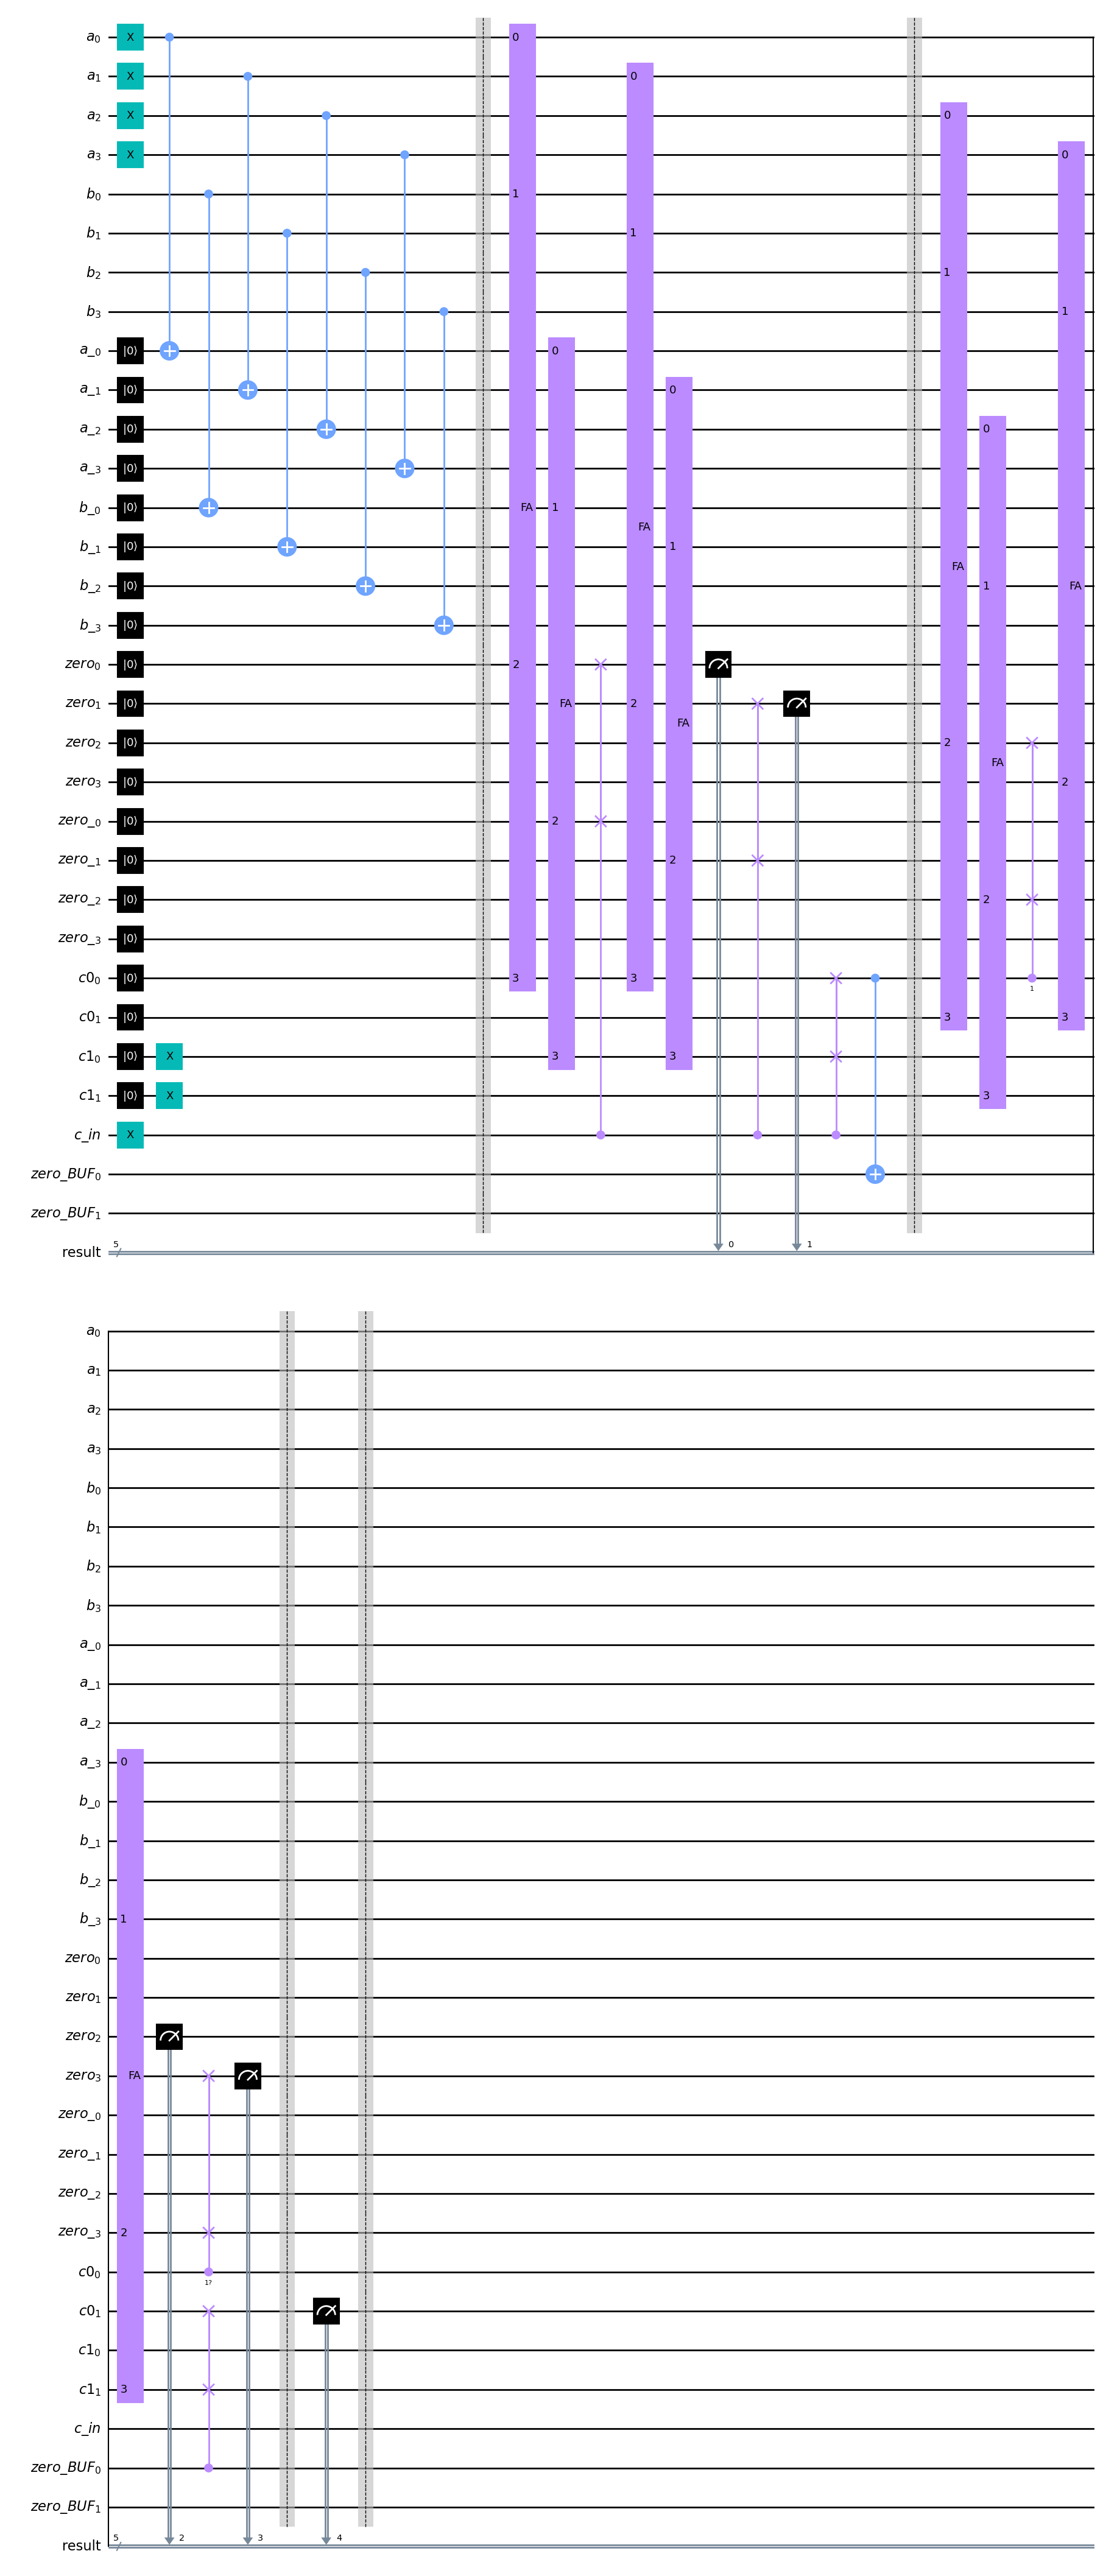

In [222]:
# NB: use n s.t. (n % 2 == 0)
n = 4
a = '1' * n
b = '0' * n
RCSA_ = circuit_RCSA_v1(n, a, b, '1')
RCSA_.draw(output="mpl", vertical_compression="high")

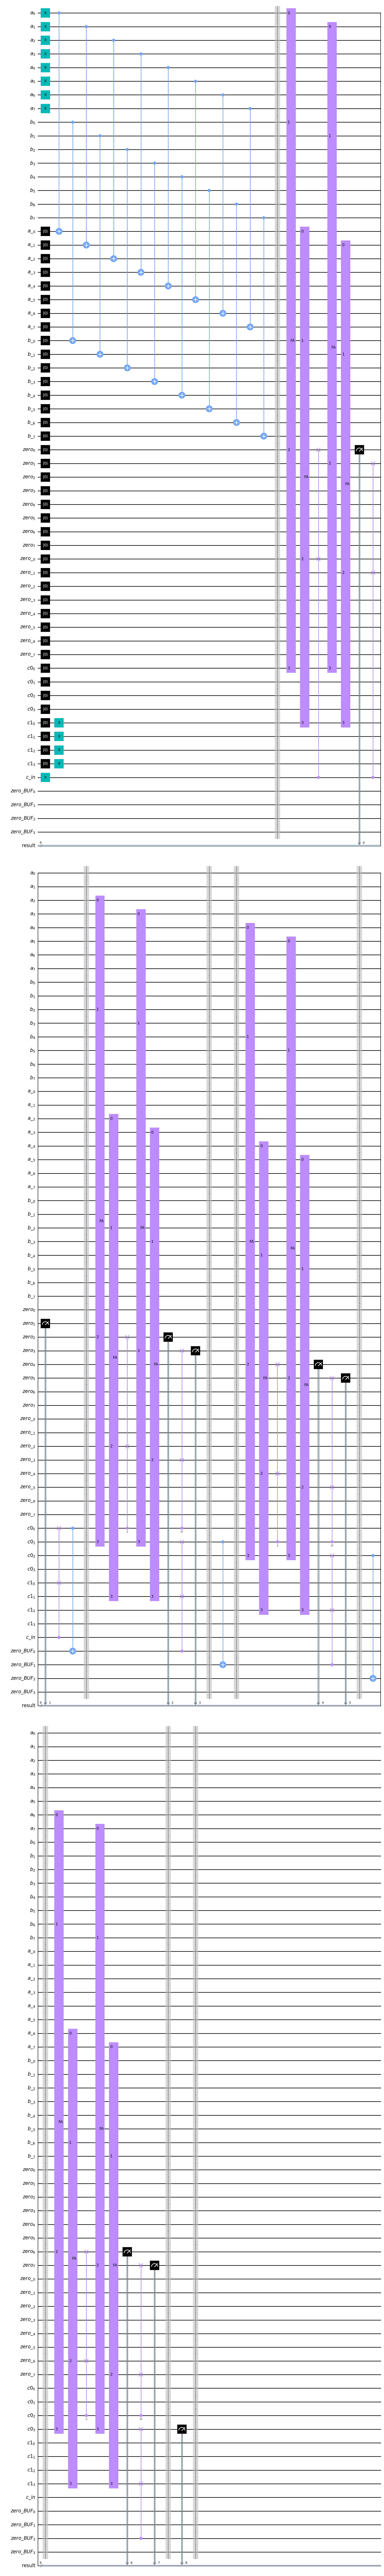

In [214]:
# NB: use n s.t. (n % 2 == 0)
n = 8
a = '1' * n
b = '0' * n
RCSA_ = circuit_RCSA_v1(n, a, b, '1')
RCSA_.draw(output="mpl", vertical_compression="high")

In [221]:
check_correctness(4,'1', circuit_RCSA_v1)

['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']
abc 		 c s
-------------
0000+0000+1 	 0 0001 True
0000+0001+1 	 0 0010 True
0000+0010+1 	 0 0011 True
0000+0011+1 	 0 0100 True
0000+0100+1 	 0 0101 True
0000+0101+1 	 0 0110 True
0000+0110+1 	 0 0111 True
0000+0111+1 	 0 1000 True
0000+1000+1 	 0 1001 True
0000+1001+1 	 0 1010 True
0000+1010+1 	 0 1011 True
0000+1011+1 	 0 1100 True
0000+1100+1 	 0 1101 True
0000+1101+1 	 0 1110 True
0000+1110+1 	 0 1111 True
0000+1111+1 	 1 0000 True
0001+0000+1 	 0 0010 True
0001+0001+1 	 0 0011 True
0001+0010+1 	 0 0100 True
0001+0011+1 	 0 0101 True
0001+0100+1 	 0 0110 True
0001+0101+1 	 0 0111 True
0001+0110+1 	 0 1000 True
0001+0111+1 	 0 1001 True
0001+1000+1 	 0 1010 True
0001+1001+1 	 0 1011 True
0001+1010+1 	 0 1100 True
0001+1011+1 	 0 1101 True
0001+1100+1 	 0 1110 True
0001+1101+1 	 0 1111 True
0001+1110+1 	 1 0000 True
0001+1111+1 	 1 0001 True
0010+0000+1 	 

In [220]:
check_correctness(8,'1', circuit_RCSA_v1, getRandomInputs=True, nInp=10)

['11100100', '00100100', '01011111', '00001101', '11100101', '11010011', '01011100', '10011110', '10001100', '10110000']
abc 		 c s
-------------
11100100+11100100+1 	 1 11001001 True
11100100+00100100+1 	 1 00001001 True
11100100+01011111+1 	 1 01000100 True
11100100+00001101+1 	 0 11110010 True
11100100+11100101+1 	 1 11001010 True
11100100+11010011+1 	 1 10111000 True
11100100+01011100+1 	 1 01000001 True
11100100+10011110+1 	 1 10000011 True
11100100+10001100+1 	 1 01110001 True
11100100+10110000+1 	 1 10010101 True
00100100+11100100+1 	 1 00001001 True
00100100+00100100+1 	 0 01001001 True
00100100+01011111+1 	 0 10000100 True
00100100+00001101+1 	 0 00110010 True
00100100+11100101+1 	 1 00001010 True
00100100+11010011+1 	 0 11111000 True
00100100+01011100+1 	 0 10000001 True
00100100+10011110+1 	 0 11000011 True
00100100+10001100+1 	 0 10110001 True
00100100+10110000+1 	 0 11010101 True
01011111+11100100+1 	 1 01000100 True
01011111+00100100+1 	 0 10000100 True
01011111+01011111+

## RCSA_ - design 1 - v2: 2 submodules of 4 bits RFA adder

In [199]:
def circuit_RCSA_v2(n: int, a_inp:str, b_inp:str, c_inp:str) -> QuantumCircuit:
    """Implements a circuit for an n-bit RCSA_.

    It works, but there's redundancy in the code. There's a version with less lines,
    but the readability is not as good as this version.

    Parameters
    ----------


    Returns
    -------
    """

    name = "RCSA_ design 1"

    a_inp = a_inp[::-1] # read from LSB to MSB
    b_inp = b_inp[::-1]


    qc_rcsa = QuantumCircuit()


    a = QuantumRegister(n, name='a')
    b = QuantumRegister(n, name='b')
    a_ = QuantumRegister(n, name='a_')
    b_ = QuantumRegister(n, name='b_')

    c0 = QuantumRegister(n//4, name='c0')   # Thier number should be equals to # stages, i.e. (n // building_block_len)       # THEY CAN BE HALVED, since the second couple of RFA do not take in input a fixed 0/1
    c1 = QuantumRegister(n//4, name='c1')       # THEY CAN BE HALVED, ...

    zero = QuantumRegister(n, name='zero')   # can be renamed zero0, as in c0 and c1
    zero_ = QuantumRegister(n, name='zero_') # can be renamed zero1
    
    c_in = QuantumRegister(1, name='c_in')   # they can probably be reduced to just 1 qubit

    zero_BUF = QuantumRegister(n/2, name='zero_BUF') # n is guaranteed to be even

    result = ClassicalRegister(n+1, name='result')

    qc_rcsa = QuantumCircuit(a, b, a_, b_, zero, zero_, c0, c1, c_in, zero_BUF, result)

    # encode the input
    if c_inp == '1':
        qc_rcsa.x(c_in[0])
    
    #qc_rcsa.reset(c_in[1])
    #qc_rcsa.reset(c_in[2])
    #qc_rcsa.reset(c_in[3])
    #qc_rcsa.reset(c_in[4])
    #qc_rcsa.reset(c_in[5])

    #qc_rcsa.cx(c_in[0], c_in[1]) # copy the c_in
    #qc_rcsa.cx(c_in[0], c_in[2]) # copy the c_in
    #qc_rcsa.cx(c_in[0], c_in[3]) # copy the c_in
    #qc_rcsa.cx(c_in[0], c_in[4]) # copy the c_in
    #qc_rcsa.cx(c_in[0], c_in[5]) # copy the c_in

    for i in range(n):
        if a_inp[i] == '1':
            qc_rcsa.x(a[i])
        if b_inp[i] == '1':
            qc_rcsa.x(b[i])
        qc_rcsa.reset(a_[i])
        qc_rcsa.reset(b_[i])
        qc_rcsa.cx(a[i], a_[i])
        qc_rcsa.cx(b[i], b_[i])
        #qc_rcsa.reset(c0[i])
        #qc_rcsa.reset(c1[i])
        #qc_rcsa.x(c1[i])
        qc_rcsa.reset(zero[i])
        qc_rcsa.reset(zero_[i])

    for i in range(n//4):
        qc_rcsa.reset(c0[i])
        qc_rcsa.reset(c1[i])
        qc_rcsa.x(c1[i])

    qc_rcsa.barrier()
    



    # perform the operations
    for i in range(n):
        if i > 3: # No more in the first stage -> use c0 instead of c_in
            if i % 4 == 0:
                qc_rcsa.append(FA, [a[i], b[i], zero[i], c0[i//4]]) # i//n gives the stage I'am in
                qc_rcsa.append(FA, [a_[i], b_[i], zero_[i], c1[i//4]])
                qc_rcsa.cswap(c0[0], zero[i], zero_[i])
                qc_rcsa.barrier()
                qc_rcsa.measure(zero[i], result[i]) # s
                
            elif (i % 4) > 0 and (i % 4) < 3:
                qc_rcsa.append(FA, [a[i], b[i], zero[i], c0[i//4]])
                qc_rcsa.append(FA, [a_[i], b_[i], zero_[i], c1[i//4]])
                qc_rcsa.cswap(c0[0], zero[i], zero_[i])
                qc_rcsa.barrier()
                qc_rcsa.measure(zero[i], result[i]) # s,s
  
            else:
                qc_rcsa.append(FA, [a[i], b[i], zero[i], c0[i//4]])
                qc_rcsa.append(FA, [a_[i], b_[i], zero_[i], c1[i//4]])
                qc_rcsa.cswap(c0[0], zero[i], zero_[i])
                qc_rcsa.measure(zero[i], result[i]) # s
                qc_rcsa.barrier()

                qc_rcsa.cswap(zero_BUF[(i//4)-1], c0[i//4], c1[i//4])

                if i == (n-1): # measure c_out
                    qc_rcsa.measure(c0[i//4], result[i+1])
                else:
                    qc_rcsa.cx(c0[0], zero_BUF[floor(i/4)])
                


        else: # I'm in th first stage
            if i == 0:
                qc_rcsa.append(FA, [a[i], b[i], zero[i], c0[i]])
                qc_rcsa.append(FA, [a_[i], b_[i], zero_[i], c1[i]])
                #qc_rcsa.cswap(c_in[4-i], zero[i], zero_[i])
                qc_rcsa.cswap(c_in[0], zero[i], zero_[i])
                qc_rcsa.barrier()
                qc_rcsa.measure(zero[i], result[i]) # s0
                
            elif i > 0 and i < 3:
                qc_rcsa.append(FA, [a[i], b[i], zero[i], c0[0]])
                qc_rcsa.append(FA, [a_[i], b_[i], zero_[i], c1[0]])
                #qc_rcsa.cswap(c_in[4-i], zero[i], zero_[i])
                qc_rcsa.cswap(c_in[0], zero[i], zero_[i])
                qc_rcsa.barrier()
                qc_rcsa.measure(zero[i], result[i]) # s1,s2
  
            else:
                qc_rcsa.append(FA, [a[i], b[i], zero[i], c0[0]])
                qc_rcsa.append(FA, [a_[i], b_[i], zero_[i], c1[0]])
                #qc_rcsa.cswap(c_in[4-i], zero[i], zero_[i])
                qc_rcsa.cswap(c_in[0], zero[i], zero_[i])
                qc_rcsa.measure(zero[i], result[i]) # s3
                qc_rcsa.barrier()

                #qc_rcsa.cswap(c_in[4-i-1], c0[0], c1[0])
                qc_rcsa.cswap(c_in[0], c0[0], c1[0])

                if n == 4: # measure c_out
                    qc_rcsa.measure(c0[0], result[i+1])
                else:
                    qc_rcsa.cx(c0[0], zero_BUF[floor(i/4)])
                    qc_rcsa.barrier()




    return qc_rcsa

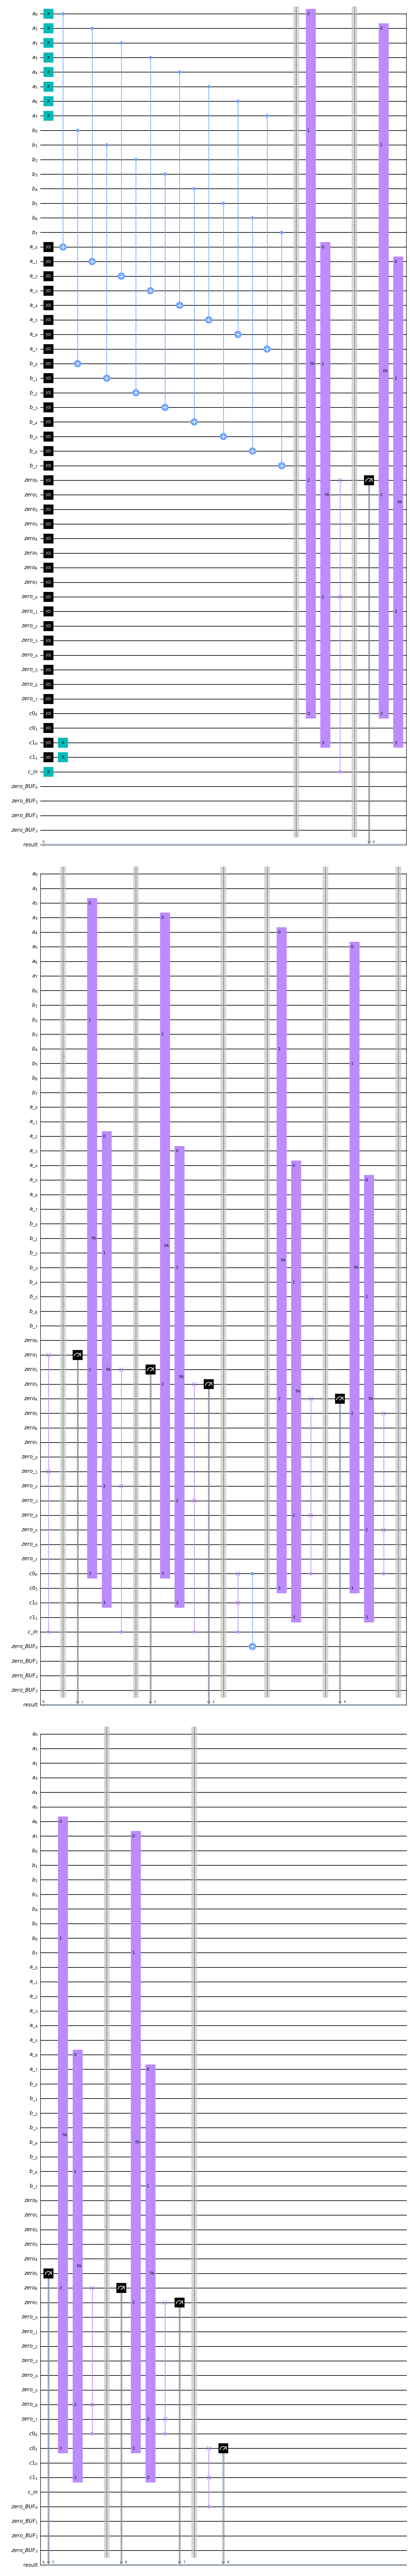

In [144]:
# NB: use n s.t. (n % 2 == 0)
n = 8
a = '1' * n
b = '0' * n
RCSA = circuit_RCSA_v2(n, a, b, '1')
RCSA.draw(output="mpl", vertical_compression="high")

In [143]:
n = 8
check_correctness(n,'1', circuit_RCSA_v2, getRandomInputs=True)

['01010011', '10100000', '01101100', '11110011', '00011111']
abc 		 c s
-------------
01010011+01010011+1 	 0 10100111 True
01010011+10100000+1 	 0 11110100 True
01010011+01101100+1 	 0 11000000 True
01010011+11110011+1 	 1 01000111 True
01010011+00011111+1 	 0 01110011 True
10100000+01010011+1 	 0 11110100 True
10100000+10100000+1 	 1 01000001 True
10100000+01101100+1 	 1 00001101 True
10100000+11110011+1 	 1 10010100 True
10100000+00011111+1 	 0 11000000 True
01101100+01010011+1 	 0 11000000 True
01101100+10100000+1 	 1 00001101 True
01101100+01101100+1 	 0 11011001 True
01101100+11110011+1 	 1 01100000 True
01101100+00011111+1 	 0 10001100 True
11110011+01010011+1 	 1 01000111 True
11110011+10100000+1 	 1 10010100 True
11110011+01101100+1 	 1 01100000 True
11110011+11110011+1 	 1 11100111 True
11110011+00011111+1 	 1 00010011 True
00011111+01010011+1 	 0 01110011 True
00011111+10100000+1 	 0 11000000 True
00011111+01101100+1 	 0 10001100 True
00011111+11110011+1 	 1 00010011 True
00

### Evaluation: v2

In [188]:
def circuit_RCSA_v1_new(n: int, a_inp:str, b_inp:str, c_inp:str) -> QuantumCircuit:
    """Implements a circuit for an n-bit RCSA_.

    It works, but there's redundancy in the code. There's a version with less lines,
    but the readability is not as good as this version.

    Parameters
    ----------


    Returns
    -------
    """

    name = "RCSA_ design 1"

    a_inp = a_inp[::-1] # read from LSB to MSB
    b_inp = b_inp[::-1]


    qc_rcsa = QuantumCircuit()


    a = QuantumRegister(n, name='a')
    b = QuantumRegister(n, name='b')
    a_ = QuantumRegister(n, name='a_')
    b_ = QuantumRegister(n, name='b_')

    c0 = QuantumRegister(n//2, name='c0')   # Thier number should be equals to # stages, i.e. (n // building_block_len)       # THEY CAN BE HALVED, since the second couple of RFA do not take in input a fixed 0/1
    c1 = QuantumRegister(n//2, name='c1')       # THEY CAN BE HALVED, ...

    zero = QuantumRegister(n, name='zero')   # can be renamed zero0, as in c0 and c1
    zero_ = QuantumRegister(n, name='zero_') # can be renamed zero1
    
    c_in = QuantumRegister(1, name='c_in')   # they can probably be reduced to just 1 qubit

    zero_BUF = QuantumRegister(n//2, name='zero_BUF') # n is guaranteed to be even

    result = ClassicalRegister(n+1, name='result')

    qc_rcsa = QuantumCircuit(a, b, a_, b_, zero, zero_, c0, c1, c_in, zero_BUF, result)

    # encode the input
    if c_inp == '1':
        qc_rcsa.x(c_in[0])
    
    #qc_rcsa.reset(c_in[1])
    #qc_rcsa.reset(c_in[2])
    #qc_rcsa.reset(c_in[3])
    #qc_rcsa.reset(c_in[4])
    #qc_rcsa.reset(c_in[5])

    #qc_rcsa.cx(c_in[0], c_in[1]) # copy the c_in
    #qc_rcsa.cx(c_in[0], c_in[2]) # copy the c_in
    #qc_rcsa.cx(c_in[0], c_in[3]) # copy the c_in
    #qc_rcsa.cx(c_in[0], c_in[4]) # copy the c_in
    #qc_rcsa.cx(c_in[0], c_in[5]) # copy the c_in

    for i in range(n):
        if a_inp[i] == '1':
            qc_rcsa.x(a[i])
        if b_inp[i] == '1':
            qc_rcsa.x(b[i])
        qc_rcsa.reset(a_[i])
        qc_rcsa.reset(b_[i])
        qc_rcsa.cx(a[i], a_[i])
        qc_rcsa.cx(b[i], b_[i])
        #qc_rcsa.reset(c0[i])
        #qc_rcsa.reset(c1[i])
        #qc_rcsa.x(c1[i])
        qc_rcsa.reset(zero[i])
        qc_rcsa.reset(zero_[i])

    for i in range(n//2):
        qc_rcsa.reset(c0[i])
        qc_rcsa.reset(c1[i])
        qc_rcsa.x(c1[i])

    qc_rcsa.barrier()
    



    # perform the operations
    for i in range(n):
        if i > 1: # No more in the first stage -> use c0 instead of c_in
            if i % 2 == 0:
                qc_rcsa.append(FA, [a[i], b[i], zero[i], c0[i//2]]) # i//n gives the stage I'am in
                qc_rcsa.append(FA, [a_[i], b_[i], zero_[i], c1[i//2]])
                qc_rcsa.cswap(c0[(i//2)-1], zero[i], zero_[i], label=str(i//2))
                #qc_rcsa.barrier()
                qc_rcsa.measure(zero[i], result[i]) # s
                
            else:
                qc_rcsa.append(FA, [a[i], b[i], zero[i], c0[i//2]])
                qc_rcsa.append(FA, [a_[i], b_[i], zero_[i], c1[i//2]])
                qc_rcsa.cswap(c0[(i//2)-1], zero[i], zero_[i], label=str(i//2) + '?')
                qc_rcsa.measure(zero[i], result[i]) # s
                

                qc_rcsa.cswap(zero_BUF[(i//2)-1], c0[i//2], c1[i//2]) # the control is now taken from the Buffer
                #qc_rcsa.barrier()

                if i == (n-1): # measure c_out
                    qc_rcsa.measure(c0[i//2], result[i+1])
                    qc_rcsa.barrier()
                else:
                    qc_rcsa.cx(c0[i//2], zero_BUF[floor(i//2)])
                    qc_rcsa.barrier()
                

        else: # I'm in th first stage
            if i == 0:
                qc_rcsa.append(FA, [a[i], b[i], zero[i], c0[i]])
                qc_rcsa.append(FA, [a_[i], b_[i], zero_[i], c1[i]])
                #qc_rcsa.cswap(c_in[4-i], zero[i], zero_[i])
                qc_rcsa.cswap(c_in[0], zero[i], zero_[i])
                #qc_rcsa.barrier()
                qc_rcsa.measure(zero[i], result[i]) # s0
                
            else:
                qc_rcsa.append(FA, [a[i], b[i], zero[i], c0[0]])
                qc_rcsa.append(FA, [a_[i], b_[i], zero_[i], c1[0]])
                #qc_rcsa.cswap(c_in[4-i], zero[i], zero_[i])
                qc_rcsa.cswap(c_in[0], zero[i], zero_[i])
                qc_rcsa.measure(zero[i], result[i]) # s3
                #qc_rcsa.barrier()

                #qc_rcsa.cswap(c_in[4-i-1], c0[0], c1[0])
                qc_rcsa.cswap(c_in[0], c0[0], c1[0])

                if n == 4: # measure c_out
                    qc_rcsa.measure(c0[0], result[i+1])
                    qc_rcsa.barrier()
                else:
                    qc_rcsa.cx(c0[0], zero_BUF[floor(i//2)])
                    qc_rcsa.barrier()




    return qc_rcsa

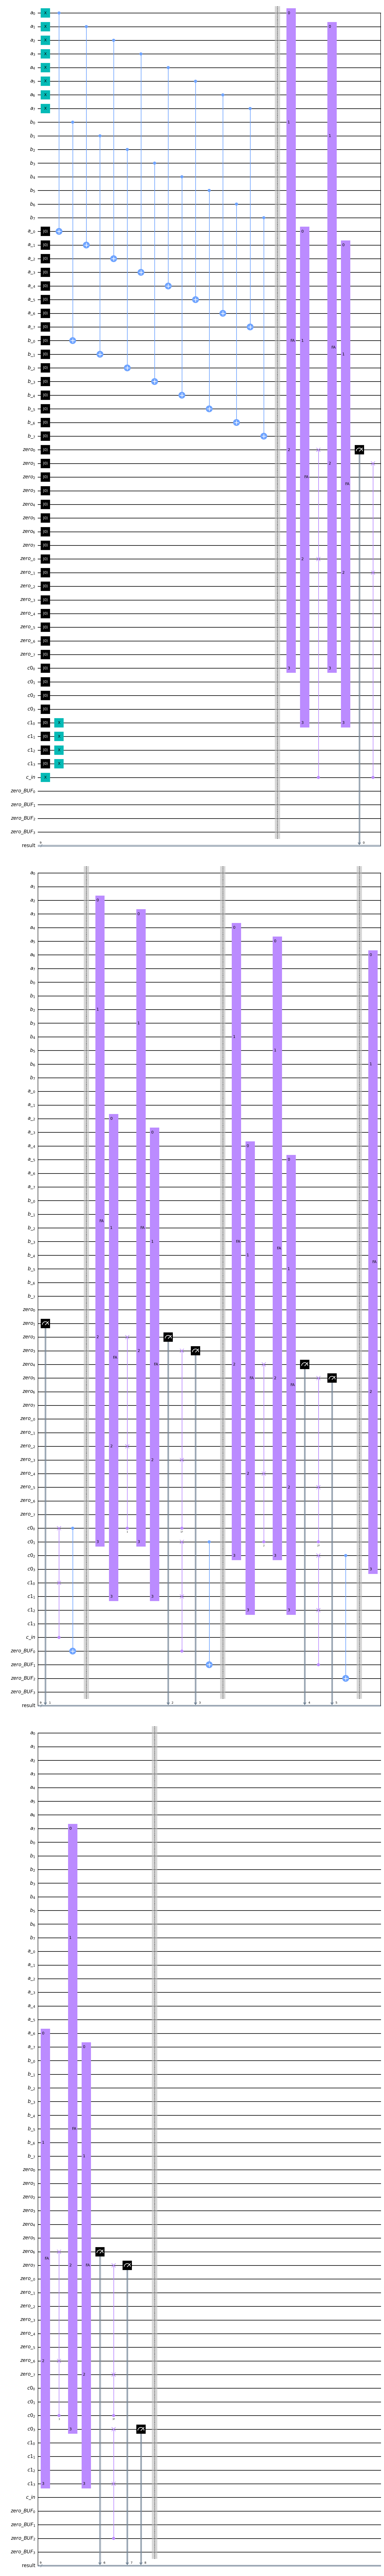

In [189]:
# NB: use n s.t. (n % 2 == 0)
n = 8
a = '1' * n
b = '0' * n
RCSA = circuit_RCSA_v1(n, a, b, '1')
RCSA.draw(output="mpl", vertical_compression="high")

In [176]:
a = '00101001'
b = '00101001'
c = '1'
bin( int(a,2) + int(b,2) + int(c, 2) )[2:]

'1010011'

In [190]:
n = 8
check_correctness(n,'1', circuit_RCSA_v1_new, getRandomInputs=True)

['01011001', '11011100', '11111110', '01101000', '11001100']
abc 		 c s
-------------
01011001+01011001+1 	 0 10110011 True
01011001+11011100+1 	 1 00110110 True
01011001+11111110+1 	 1 01011000 True
01011001+01101000+1 	 0 11000010 True
01011001+11001100+1 	 1 00100110 True
11011100+01011001+1 	 1 00110110 True
11011100+11011100+1 	 1 10111001 True
11011100+11111110+1 	 1 11011011 True
11011100+01101000+1 	 1 01000101 True
11011100+11001100+1 	 1 10101001 True
11111110+01011001+1 	 1 01011000 True
11111110+11011100+1 	 1 11011011 True
11111110+11111110+1 	 1 11111101 True
11111110+01101000+1 	 1 01100111 True
11111110+11001100+1 	 1 11001011 True
01101000+01011001+1 	 0 11000010 True
01101000+11011100+1 	 1 01000101 True
01101000+11111110+1 	 1 01100111 True
01101000+01101000+1 	 0 11010001 True
01101000+11001100+1 	 1 00110101 True
11001100+01011001+1 	 1 00100110 True
11001100+11011100+1 	 1 10101001 True
11001100+11111110+1 	 1 11001011 True
11001100+01101000+1 	 1 00110101 True
11